## PROJECT. Расчёт статистической значимости
1. Насколько различаются конверсия, средний чек и ARPU пользователей в группах А и Б (ID теста 127, даты проведения: с 2019-08-05 до 2019-08-11 включительно).
2. Выводы по анализу.

In [1]:
# импорт
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import ztest
from datetime import datetime
from matplotlib import gridspec
from math import ceil

In [2]:
pd.options.display.float_format = '{:,.4f}'.format #3.514284e+05 -> 351,428.4000

In [3]:
ab_test_groups = pd.read_csv('ab_test_groups.csv') # аб тест

In [4]:
payments = pd.read_csv('payments.csv')# платежи

In [5]:
# фильтр
ab_test_groups = ab_test_groups.loc[ab_test_groups.ab_test_id == 127] # test 127
# 2019-08-(05,...,11)
payments = payments[(payments.created_at.astype(str) >= '2019-08-05')&(payments.created_at.astype(str) < '2019-08-12')][['user_id', 'price']]

In [6]:
# group by по user_id
payments = payments.groupby('user_id',as_index = False).sum()
# join
ab_data = ab_test_groups.merge(payments, on = 'user_id', how = 'left')

In [7]:
# групировка по user_id, price
ab_summary = ab_data.groupby('grp')[['user_id','price']].count().rename(columns={'user_id':'users_count', 'price':'buyers_count'})
# conversion
ab_summary['conversion'] = ab_summary.buyers_count/ab_summary.users_count
# средний чек
ab_summary = ab_summary.merge(ab_data.groupby('grp').agg({'price':'mean'}).rename(columns = {'price':'avg_bill'}), 
                 left_index = True, right_index = True)
# прибыль
ab_summary = ab_summary.merge(ab_data.groupby('grp').agg({'price':'sum'}).rename(columns = {'price':'revenue'}), 
                 left_index = True, right_index = True)
# средняя прибыль на пользователя
ab_summary['ARPU'] = ab_summary.revenue/ab_summary.users_count
# profit 
ab_summary['Доп. выручка'] = (ab_summary.users_count*(ab_summary.ARPU - ab_summary['ARPU']['A'])).astype(int)

In [8]:
# Важные функции для получения доверительных интервалов
def get_conf_interval(data, conf_level = 0.95):  
# Считает доверительные интервалы для средних
        buf = (stats.t.interval(conf_level, len(data),
                             loc=np.mean(data), scale=stats.sem(data)))
        return (buf[1] - buf[0])/2
    
def get_conf_interval_z(succ, tot):  
# Считает доверительные интервалы для бинарных величин
    buf = proportion_confint(succ, tot)
    return buf[1] - buf[0]

In [9]:
# Составляем словарь с доверительными интервалами для каждой метрики и для каждой группы
conf_intervals = {'ARPU':{'A':get_conf_interval(ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0)),
                          'B':get_conf_interval(ab_data.loc[ab_data.grp == 'B', 'price'].fillna(0))},
                  'conversion':{'A':get_conf_interval_z(ab_data.loc[ab_data.grp == 'A', 'price'].dropna().count(),
                                                        ab_data.loc[ab_data.grp == 'A', 'user_id'].count()),
                               'B':get_conf_interval_z(ab_data.loc[ab_data.grp == 'B', 'price'].dropna().count(),
                                                        ab_data.loc[ab_data.grp == 'B', 'user_id'].count())},
                  'avg_bill':{'A':get_conf_interval(ab_data.loc[ab_data.grp == 'A', 'price'].dropna()),
                          'B':get_conf_interval(ab_data.loc[ab_data.grp == 'B', 'price'].dropna())}
                 }

In [10]:
# Удобная функция для подстановки подписей на barplot
def set_labels(axes):  
# Расставляет подписи столбцов на барплоты
    y0, y1 = axes.get_ybound()  
# размер графика по оси Y
    y_shift = 0.15* (y1 - y0)  
# дополнительное место под надписи

    for i, rect in enumerate(axes.patches):  
# по всем нарисованным прямоугольникам
        height = rect.get_height()
        if abs(height) <= 10000:
            label = str(round(height, 2))
            if label[-1] == '0':
                label = label[:-1]
        elif abs(height) <= 1000000:
            label = str(round(height/1000, 1))
            if label[-1] == '0':
                label = label[:-1] + 'k'
            else:
                label = label + 'k'
        else:
            label = str(round(height/1000000, 2))
            if label[-1] == '0':
                label = label[:-1] + 'm'
            else:
                label = label + 'm'
        x = rect.get_x() + rect.get_width() / 2  
# посередине прямоугольника
        y = height + y_shift * 0.8  
# над прямоугольником в середине доп. места
        if height < 0:
            y = y_shift * 0.8 
        axes.text(x, y, label, ha='center', va='center', alpha = 0.7)
        axes.set_ybound(y0, y1 + 1.5*y_shift)

In [11]:
plot_summary = ab_summary.T 
# Транспонированная таблица для удобства использования
significant_changes = ['conversion', 'avg_bill'] 
# Метрики со статзначимыми различиями

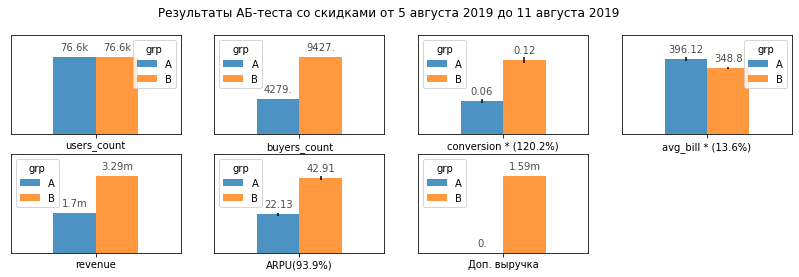

In [12]:

ax = [] 
# Массив для складирования графиков
n_pict_in_line = 4 
# Количество картинок в одной линии

gs = gridspec.GridSpec(ceil(len(plot_summary) / float(n_pict_in_line)), n_pict_in_line) 
# Создаём сетку для графиков
fig = plt.figure(figsize=(n_pict_in_line*3 + 2,
                          ceil(len(plot_summary) / n_pict_in_line) * 2))

## Считаем изменение метрики в процентах
delta_percent = {}
for row in plot_summary.index:  
    if 'users_count' != row and 'buyers_count' != row and 'revenue' != row and "Доп. выручка" != row:
        delta_percent[row] = '(' + str(round(plot_summary.loc[row, :].max()/\
                                  plot_summary.loc[row, :].min()*100 - 100, 1)) + '%)'
        
fig.suptitle('Результаты АБ-теста со скидками от 5 августа 2019 до 11 августа 2019')

## Строим графики
for i, col in enumerate(plot_summary.index):
    ax.append(plt.subplot(gs[i // n_pict_in_line, i % n_pict_in_line])) 
# Добавляем subplot в нужную клетку
    plot_summary.loc[[col], :].plot(kind='bar', rot=0, ax=ax[i], alpha=0.8, 
# Строим график в нужной клетке
                                   yerr=conf_intervals[col] if col in conf_intervals else 0) 
    
    
# Редактируем подпись к графику, чтобы в ней хранилась информация о значимости различий 
    stars = ' * ' if col in significant_changes else '' 
    ticks = ax[-1].get_xticklabels()
    ticks[0] = col + stars + delta_percent[col] if col in delta_percent else col + stars
    ax[-1].set_xticklabels(ticks)
    ax[-1].set_yticks([])
    set_labels(axes=ax[i])

In [13]:
ab_summary

,users_count,buyers_count,conversion,avg_bill,revenue,ARPU,Доп. выручка
grp,,,,,,,
A,76605,4279,0.0559,396.1206,"1,695,000.0000",22.1265,0
B,76627,9427,0.1230,348.8045,"3,288,180.0000",42.9115,1592693


### Cредний чек

In [14]:
ab_summary['avg_bill']

grp
A   396.1206
B   348.8045
Name: avg_bill, dtype: float64

### ARPU

In [15]:
ab_summary['ARPU']

grp
A   22.1265
B   42.9115
Name: ARPU, dtype: float64

### Выводы по анализу
ARPU показал рост на 93,9 % что много, и значимо.

Средний чек, упал на 13,6 % что сильное падение, но не очень бросающаяся в глаза из-за, конверсии значимо увеличившейся на 120 %.
Мы получили доп. выручки 1,592 млн.руб. от пользователей из тестовой группы со скидками.

**Скидки успешная концепция, и приносит ощутимую прибыль. Значит маркетологи могут запускать ещё события.**